In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing
import math
import unicodedata, re

%config InlineBackend.figure_format = 'png'
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [13]:
acquired_dict = {
    'tr':'tr',
    'fa':'fa',
    'dr':'dr',
    "Traded": "tr",
    "Free Agency": "fa",
    "Amateur Draft": "dr",
    "Amateur Free Agent": "fa",
    "Waivers": "tr",
    "Purchased":"tr",
    "Rule 5 Draft": "dr",
    "Expansion Draft": "dr",
    "Conditional Deal": "tr",
    "Amateur Draft--no sign": "dr",
    "MinorLg Draft": "dr",
    "Rune 5 returned": "tr"
}

def inflation_calc(row):
    inf_dict = {
     2017: 1.0,
     2016: 1.021299290023666,
     2015: 1.0341874211554445,
     2014: 1.0354149770208165,
     2013: 1.0522113523096537,
     2012: 1.0676237183898534,
     2011: 1.089717656786951,
     2010: 1.1241149062626115,
     2009: 1.1425534989302544,
     2008: 1.1384885486964882,
     2007: 1.1822013870802828,
     2006: 1.215873015873016,
     2005: 1.2550947260624679,
     2004: 1.297617787188989,
     2003: 1.3324635790389214,
     2002: 1.3626862352679565,
     2001: 1.3843112893206078,
     2000: 1.4234610917537749
    }
    return int(row['salary']*inf_dict[row['year']])

def fixtm(t):
    if t == '2TM' or t == '3TM' or t == '4TM':
        return 'multiple'
    elif t == 'TBD':
        return 'TBR'
    elif t == 'MON':
        return "WSN"
    elif t == 'ANA':
        return 'LAA'
    elif t == 'FLA':
        return 'MIA'
    else: return t
    
    
def fix_name(n):
    n = (' ').join(n.split('\xa0'))
    return re.sub(r'[^\w\s]','',n)

In [4]:
def train_and_test(cutoff = 1000000):
    train_X,train_y,test_X,test_y = load_and_split_data(cutoff)

    
    lr = LinearRegression()

    lr.fit(train_X, train_y)

    preds = lr.predict(test_X)

    error = np.sqrt(MSE(test_y,preds))
    
    return round(10**error,2)

In [5]:
def cutoff_df(df,cutoff):
    log_10_cut = math.log10(cutoff)
    df = df[df['log10_adj'] >= log_10_cut]
    return df

In [6]:
def test_cutoffs():
    test_cutoffs = [(i+1)*100000 for i in range(20)]
    error_list = []
    for i in test_cutoffs:
        error = train_and_test(i)
        error_list.append(error)
    return test_cutoffs,error_list

In [7]:
def load_data():
    train = pd.read_pickle('batting_00_16.pkl')
    test = pd.read_pickle('batting_17.pkl')
    return train,test

In [14]:
def engineer_features(df):
    df = df[df.pa>200]

    df = df.reset_index()
    
    df['name'] = df['name'].apply(fix_name)
    #adjust team names
    df['tm'] = df['tm'].apply(fixtm)
    #drop position summary (too many classes), log_sal (unscaled by inflation), rk (same as index)
    df.drop(['pos\xa0summary','log_sal','rk','index'],axis=1,inplace=True)
    #map values in acquired to 3 classes
    df['acquired'] = df['acquired'].map(acquired_dict)
    
    #adjust salary for inflation and take the log-10 for target column
    df['adj_salary'] = df.apply(inflation_calc,axis=1)
    df['log10_adj'] = np.log10(df['adj_salary'])
    
    #get dummy variables for team, hand, and acquired columns
    df = pd.get_dummies(df,columns = ['acquired','bat_hand','tm']).drop(['tm_multiple','bat_hand_rhb','acquired_tr'],axis=1)
    #filter datasets for only batters with more than 200 plate appearances in season

    return df

def scaleColumns(df, cols_to_scale):
    min_max_scaler = preprocessing.MinMaxScaler()
    for col in cols_to_scale:
        df[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df    

def rescale_numeric(df):
    
    cols = [ 'g',
         'pa',
         'rbat',
         'rbaser',
         'rdp',
         'rfield',
         'rpos',
         'raa',
         'waa',
         'rrep',
         'rar',
         'war',
         'waawl%',
         '162wl%',
         'owar',
         'dwar',
         'orar',
         'year',]
    df = scaleColumns(df,cols)

    return df

In [9]:
def load_and_split_data(cutoff = 1):
    #Load dataframes from pickle
    train,test = load_data()
    
    #Scale inflation and engineer categorical features
    train = engineer_features(train)
    test = engineer_features(test)
    
    #Rescale numeric features to be (0,1)
    train = rescale_numeric(train)
    test = rescale_numeric(test)
    
    #Cut dataframe by minimum salary
    train = cutoff_df(train,cutoff)
    test = cutoff_df(test,cutoff)
    
    #Split into features and response matrices
    train_y = train['log10_adj']
    test_y = test['log10_adj']
    train_X = train.drop(['name','age','log10_adj'],axis=1)
    test_X = test.drop(['name','age','log10_adj'],axis=1)
    
    return train_X, train_y, test_X, test_y

In [94]:
a,b,c,d = load_and_split_data(1)

In [105]:
train_and_test(500000)

'The error is a factor of 1.92'

In [112]:
cut,err = test_cutoffs()

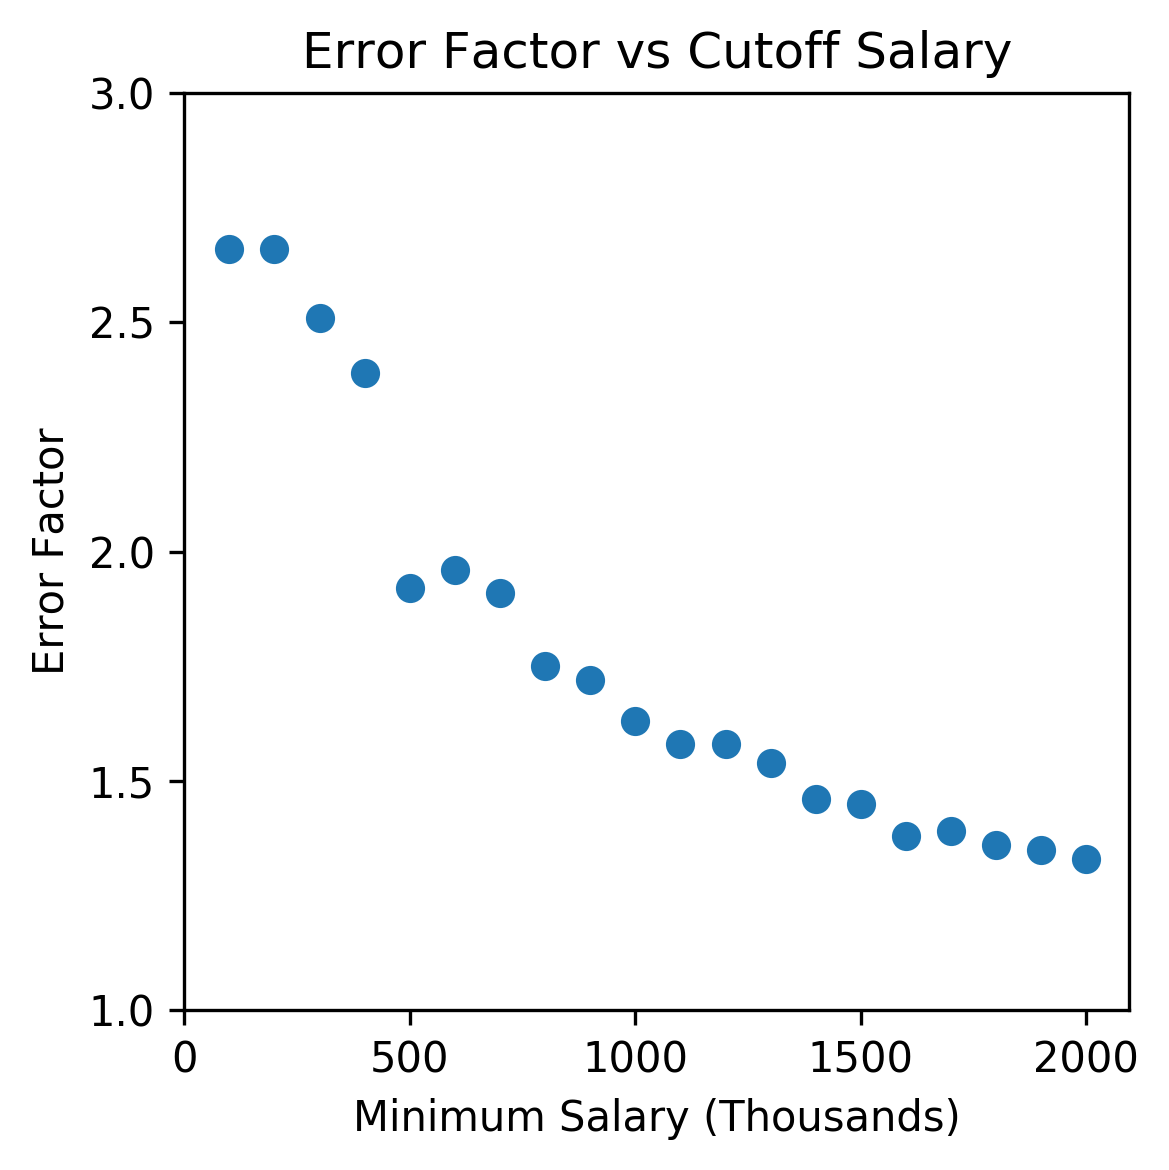

In [193]:
fig,ax = plt.subplots(figsize=(4,4))

ax.scatter([i/1000 for i in cut],err)
ax.set_title("Error Factor vs Cutoff Salary")
ax.set_ylabel("Error Factor")
ax.set_xlabel("Minimum Salary (Thousands)")
ax.set_yticks([1,1.5,2,2.5,3]);
ax.set_xticks([0,500,1000,1500,2000]);
plt.tight_layout()
plt.savefig('cutofferr.png')

In [129]:
min_sal_year = a.join(b).groupby(['year'])['log10_adj'].min()

In [133]:
min_sal_df = pd.DataFrame(min_sal_year)

In [135]:
min_sal_df['salary'] = 10**min_sal_df['log10_adj']

In [138]:
min_sal_df.reset_index(inplace=True)

In [145]:
min_sal_df['fix_year'] = (min_sal_df['year']*16 +2000).astype(int)

In [146]:
min_sal_df

,year,log10_adj,salary,fix_year
0,0.0000,5.454375,284692.0,2000
1,0.0625,5.442263,276862.0,2001
2,0.1250,5.435425,272537.0,2002
3,0.1875,5.343647,220621.0,2003
4,0.2500,5.590268,389285.0,2004
5,0.3125,5.598363,396609.0,2005
6,0.3750,5.562008,364761.0,2006
7,0.4375,5.652475,449236.0,2007
8,0.5000,5.647393,444010.0,2008
9,0.5625,5.659936,457021.0,2009


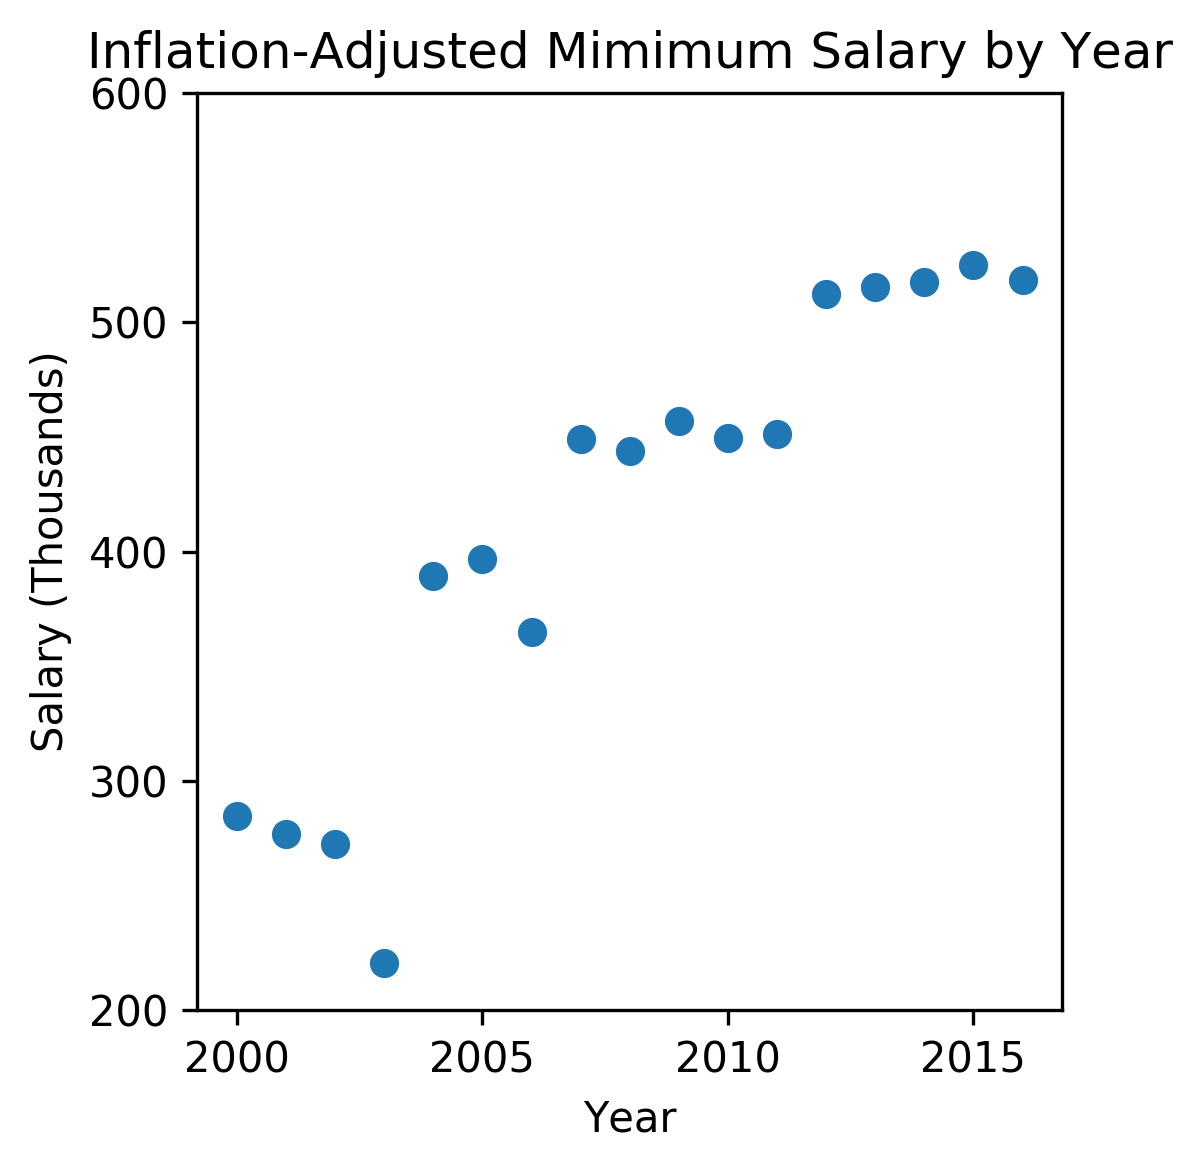

In [192]:
fig,ax = plt.subplots(figsize=(4,4))

ax.scatter(min_sal_df.fix_year,min_sal_df.salary/1000)
ax.set_title('Inflation-Adjusted Mimimum Salary by Year')
ax.set_yticks([200,300,400,500,600])
ax.set_ylabel("Salary (Thousands)")
ax.set_xlabel("Year");
plt.tight_layout()
plt.savefig('adjmin.png')

In [163]:
full_train = a.join(b)

full_train['salary'] = 10**full_train['log10_adj']

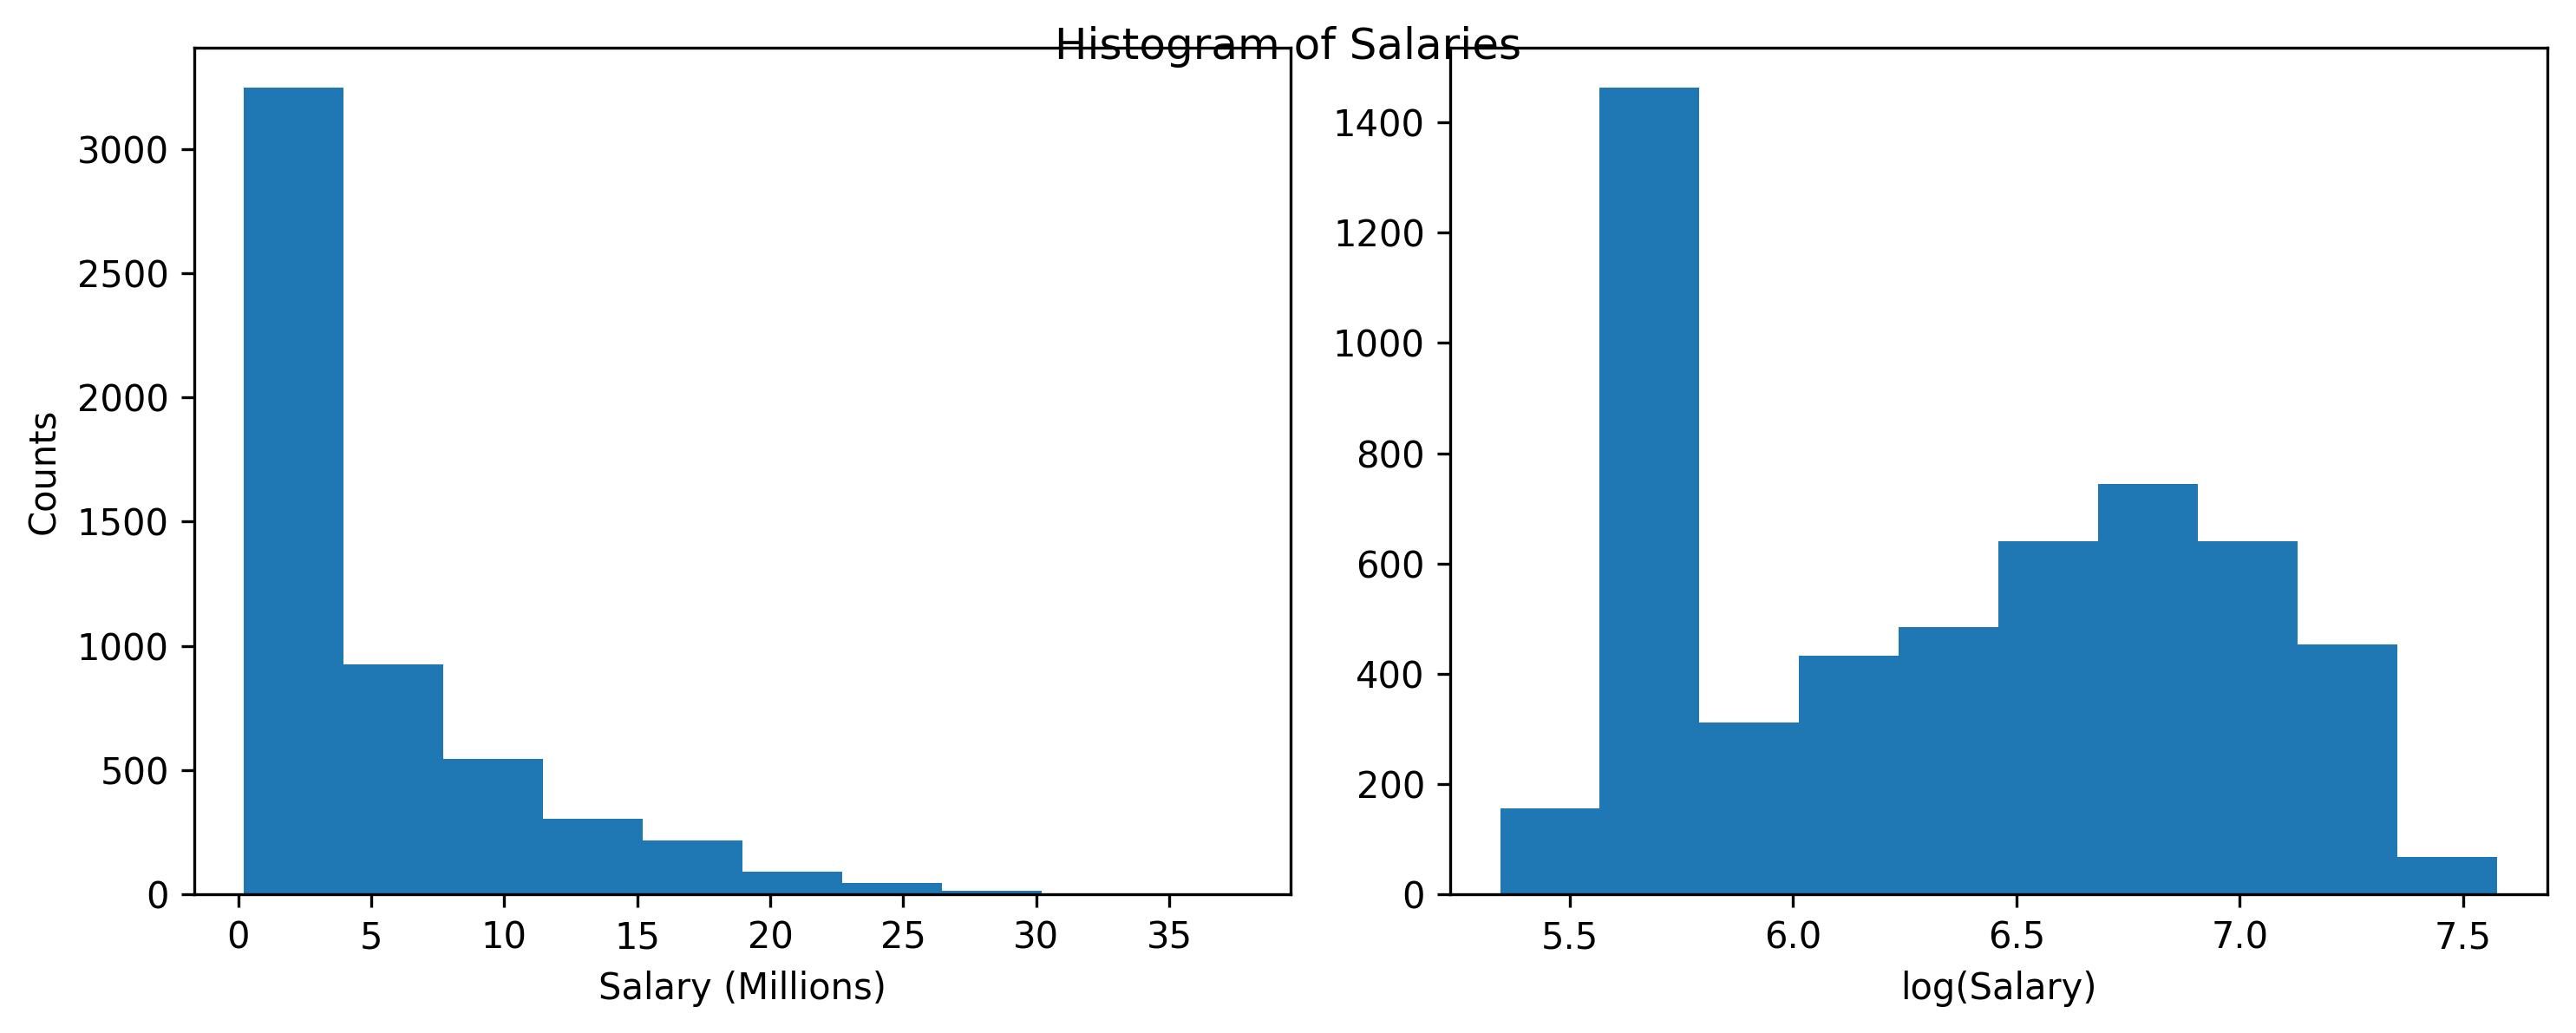

In [191]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.hist(full_train['salary']/1000000)
ax2.hist(full_train['log10_adj'])
fig.suptitle("Histogram of Salaries")
ax1.set_ylabel('Counts')
ax1.set_xlabel("Salary (Millions)")
ax2.set_xlabel('log(Salary)');
plt.tight_layout()
plt.savefig('salaryhist.png')


In [189]:
a.shape

(5395, 54)

In [190]:
c.shape

(315, 54)

In [10]:
tr,te = load_data()

In [11]:
tr.shape

(13464, 27)